<a href="https://colab.research.google.com/github/2021-FIIT-Bc-projects/BP-Eliseeva-Najdiskutovanejsie_temy_v_dokumentoch/blob/main/Bakalarka_vsetky_experementy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funkcie, include atd.

## Includes

In [22]:
pip install pyLDAvis

In [23]:
import gensim
import nltk
import pandas as pd
import re
import collections
import itertools
import warnings
import pyLDAvis
import pyLDAvis.gensim_models
import scipy
import random
import numpy as np
import warnings
import matplotlib.pyplot as plt
import spacy
import pkg_resources

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from gensim import corpora
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from pprint import pprint
from nltk.tokenize import word_tokenize


In [24]:
print(pkg_resources.get_distribution('gensim').version)
print(pkg_resources.get_distribution('nltk').version)
print(pkg_resources.get_distribution('pandas').version)
print(pkg_resources.get_distribution('spacy').version)
print(pkg_resources.get_distribution('pyLDAvis').version)
print(pkg_resources.get_distribution('wordcloud').version)
print(pkg_resources.get_distribution('matplotlib').version)
print(pkg_resources.get_distribution('scikit-learn').version)
print(pkg_resources.get_distribution('numpy').version)

3.6.0
3.2.5
1.3.5
2.2.4
3.3.1
1.5.0
3.2.2
1.0.2
1.21.6


In [25]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
# stop_words.extend(['let', 'fig', 'node', 'neuron', 'neural'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# nlp.Defaults.stop_words |= {'let', 'fig', 'node', 'neuron', 'neural'}

warnings.filterwarnings("ignore", category=DeprecationWarning) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Visualization

In [26]:
def create_clusters_svd(lda_model):
  distr = [lda_model[corpus_all[i]]for i in range(len(data))]

  top_topics = [max(i,key=lambda item:item[1]) for i in distr]

  df_topic_distribution = pd.DataFrame(top_topics, columns =['Topic', 'Value'])
  df_topic_distribution = df_topic_distribution['Topic'].value_counts().reset_index(name="Num Documents")
  df_topic_distribution['Words'] = lda_model.show_topics(num_words=10, log=False, formatted=True)
  df_topic_distribution.columns = ['Topic Num', 'Num Documents', 'Words']
  df_topic_distribution.drop('Topic Num', axis=1, inplace=True)
  pd.set_option('max_colwidth', 400)
  print(df_topic_distribution)
  
  lda_output = []
  for i in range(len(data)):
    top_topics = lda_model.get_document_topics(corpus_all[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(lda_model.num_topics)]
    lda_output.append(topic_vec)

  clusters = KMeans(n_clusters=lda_model.num_topics, random_state=100).fit_predict(lda_output)

  if len(lda_output[0]) > 2:
    # Build the Singular Value Decomposition(SVD) model
    svd_model = TruncatedSVD(n_components=2)  # 2 components
    lda_output_svd = svd_model.fit_transform(lda_output)

    # X and Y axes of the plot using SVD decomposition
    x = lda_output_svd[:, 0]
    y = lda_output_svd[:, 1]
    print("Component's weights: \n", np.round(svd_model.components_, 2))

    # Percentage of total information in 'lda_output' explained by the two components
    print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))
    plt.figure(figsize=(12, 12))
    plt.scatter(x, y, c=clusters)
  else:
    print('only two clusters')


## Tuning function

In [55]:
def hypertuning(corpus_train, id2word, data, limit=15, start=2, step=2):
  model_results = { 
                    'num_topics': [],
                    'coherence': [],
                    'chunksize': [],
                    'eta': []
                  }

  eta = [0.1, 0.3, 0.5, 0.7, 0.9, 'symmetric', 'auto']
  for e in eta:
    for chunk in range(100, 500, 200):
      for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                chunksize=chunk,                                            
                                                passes=2,
                                                eta=e)
        coherence_model = CoherenceModel(model=model, texts=data, dictionary=id2word, coherence='u_mass')
        coh = coherence_model.get_coherence()
        model_results['num_topics'].append(num_topics)
        model_results['chunksize'].append(chunk)
        model_results['coherence'].append(coh)
        model_results['eta'].append(e)
        print(coh)
  best_res = max(model_results['coherence'])
  i = model_results['coherence'].index(best_res)
  best_topic = model_results['num_topics'][i]
  best_eta = model_results['eta'][i]
  best_chunk = model_results['chunksize'][i]

  best_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                                id2word=id2word,
                                                num_topics=best_topic,
                                                chunksize=best_chunk,
                                                random_state=100,
                                                passes=2,
                                                eta=best_eta)

  return best_model


## Preprocessing functions

In [29]:
def measure_model(model, test, all, id2word):
  #perplexity
  print(model.log_perplexity(test))
  #coherence
  coherence_model_lda = CoherenceModel(model=model, texts=all, dictionary=id2word, coherence='u_mass')
  print(coherence_model_lda.get_coherence())

def ShowWordCloud(data):
    string = ','.join(str(text) for text in data)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, max_font_size=60, regexp=r"\w[\w']+\w").generate(string)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)


def remove_stopwords_spacy(texts):
  filtered_texts = []
  for text in texts:
    filtered_sentence = [] 
    for word in text:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    filtered_texts.append(filtered_sentence)
  return filtered_texts

def remove_stopwords_nltk(texts):
  filtered_texts = []
  for doc in texts:
    filtered_sentence = []
    for word in gensim.utils.simple_preprocess(str(doc)):
      if word not in stop_words:
        filtered_sentence.append(word)
    filtered_texts.append(filtered_sentence)
  return filtered_texts

def remove_twosymbols(texts):
  for text in texts:
    for word in text:
      if len(word) <= 2:
        text.remove(word)
  return texts

def countWordsTotal(texts):
    total = 0
    for text in texts:
        total += len(text)
    return total

def prepare_data(data):
    data_words = list(sent_to_words(data))
    # ShowWordCloud(data_words)

    print("Povodny text po tokenizacii, pocet slov:")
    print(countWordsTotal(data_words))
    print(data_words[0][:50])

    data_lemmatized = []
    for text in data_words:
        doc = nlp(" ".join(text))
        data_lemmatized.append([token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])

    # print("Pocet slov po lemmatizacii:")
    # print(countWordsTotal(data_lemmatized))
    # print(len(data_lemmatized[0]))
    # print(data_lemmatized[0][:50])

    data_words_nostops = remove_stopwords_spacy(data_lemmatized)
    # print("Pocet slov po opakovanom vymazani stop-slov:")
    # print(countWordsTotal(data_words_nostops))
    # print(len(data_words_nostops[0]))
    # print(data_words_nostops[0][:50])

    bigram = gensim.models.Phrases(data_words_nostops, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    data_bigrams = [bigram_mod[text] for text in data_words_nostops]

    result = remove_twosymbols(data_bigrams)
    print("Pocet slov po vymazani dvojpismenkovych a menej slov:")
    print(countWordsTotal(result))
    print(len(result[0]))
    print(result[0][:50])

    ShowWordCloud(result)
    return result

def clean_data(df, text_column):
  df2 = df[text_column].str.replace('[ \t\n\r\f\v]', " ")
  df2 = df2.str.replace(r"\S*@\S*\s?", "")
  df2 = df2.str.lower()
  tmp = []
  for i in range(len(df2)):
    if len(word_tokenize(str(df2[i]))) < 5:
        tmp.append(i)
  df2 = df2.drop(tmp)
  df2 = df2.reset_index(drop=True)
  return df2

In [30]:
pip freeze > requirements.txt

# Data loading and preprocessing

### Fyzika

In [9]:
df_physics = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/physics.csv')
df_physics = df_physics['text'].str.replace(r'\\\\', "Я")
df_physics = df_physics.str.split('Я')
tmp = []
for t in df_physics:
  tmp.append(t[2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [10]:
df = pd.DataFrame(tmp, columns =['abstract'])
physics_cleaned = clean_data(df, 'abstract')
# physics_cleaned = physics_cleaned[:500]
physics_prepared = prepare_data(physics_cleaned.values)
physics_prepared[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
1062383
['these', 'are', 'notes', 'based', 'on', 'lectures', 'given', 'at', 'tasi', 'we', 'review', 'the', 'geometry', 'of', 'the', 'moduli', 'space', 'of', 'theories', 'in', 'four', 'dimensions', 'from', 'the', 'point', 'of', 'view', 'of', 'superstring', 'the', 'cases', 'of', 'type', 'iia', 'or', 'type', 'iib', 'string', 'compactified', 'on', 'calabi', 'yau', 'threefold', 'and', 'the', 'heterotic', 'string', 'compactified', 'on', 'xt']


KeyboardInterrupt: ignored

### BBC business

In [ ]:
df_bbc = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/articles_bbc/business.csv')
df_bbc

In [ ]:
bbc_cleaned = clean_data(df_bbc, "text")
bbc_prepared = prepare_data(bbc_cleaned.values)
bbc_prepared[0]

### Biologia

In [ ]:
df_bio = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/biology.txt', sep=';', header=None, names=["id", "med", "Aut", "title", "cit", "type", "genes", "abstract"])
df_bio

In [ ]:
bio_cleaned = clean_data(df_bio, "abstract")
# bio_cleaned = bio_cleaned[:500]
bio_prepared = prepare_data(bio_cleaned.values)
bio_prepared[0]

### NIPS

In [11]:
df_nips = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/papers.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
466569
['non', 'negative', 'matrix', 'factorization', 'nmf', 'has', 'previously', 'been', 'shown', 'to', 'be', 'useful', 'decomposition', 'for', 'multivariate', 'data', 'two', 'different', 'multi', 'plicative', 'algorithms', 'for', 'nmf', 'are', 'analyzed', 'they', 'differ', 'only', 'slightly', 'in', 'the', 'multiplicative', 'factor', 'used', 'in', 'the', 'update', 'rules', 'one', 'algorithm', 'can', 'be', 'shown', 'to', 'minimize', 'the', 'conventional', 'least', 'squares', 'error']
Pocet slov po vymazani dvojpismenkovych a menej slov:
240014
41
['factorization', 'nmf', 'previously', 'useful', 'decomposition', 'multivariate', 'datum', 'different', 'multi', 'plicative', 'algorithm', 'nmf', 'analyze', 'differ', 'slightly', 'multiplicative', 'factor', 'update', 'rule', 'minimize', 'conventional', 'error', 'minimize', 'generalize', 'divergence', 'monotonic', 'algorithm', 'prove', 'tion', 'analogous', 'prove', 'expectation_maximization', 'interpret'

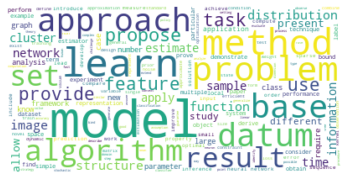

['factorization',
 'nmf',
 'previously',
 'useful',
 'decomposition',
 'multivariate',
 'datum',
 'different',
 'multi',
 'plicative',
 'algorithm',
 'nmf',
 'analyze',
 'differ',
 'slightly',
 'multiplicative',
 'factor',
 'update',
 'rule',
 'minimize',
 'conventional',
 'error',
 'minimize',
 'generalize',
 'divergence',
 'monotonic',
 'algorithm',
 'prove',
 'tion',
 'analogous',
 'prove',
 'expectation_maximization',
 'interpret',
 'onally',
 'rescale',
 'gradient_descent',
 'factor',
 'optimally',
 'choose',
 'ensure',
 'convergence']

In [12]:
nips_cleaned = clean_data(df_nips, "abstract")
# nips_cleaned = nips_cleaned[:500]
nips_prepared = prepare_data(nips_cleaned.values)
nips_prepared[0]

### Covid

In [ ]:
df_covid = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/covid.csv', nrows=3000)
df_covid

In [ ]:
covid_cleaned = clean_data(df_covid, "abstract")
# covid_cleaned = covid_cleaned[:500]
covid_prepared = prepare_data(covid_cleaned.values)
covid_prepared[0]

### Vino

In [ ]:
df_wine = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/wine.csv', nrows=3000)
df_wine

In [ ]:
wine_cleaned = clean_data(df_wine, "description")
# covid_cleaned = covid_cleaned[:500]
wine_prepared = prepare_data(wine_cleaned.values)
wine_prepared[0]

### Dlzky

In [ ]:
len(nips_prepared)

In [ ]:
len(physics_prepared)

In [ ]:
len(bbc_prepared)

In [ ]:
len(bio_prepared)

In [ ]:
len(covid_prepared)

In [ ]:
len(wine_prepared)

# Exp1

## Creating dictionary

In [25]:
nips_sampled = random.sample(nips_prepared, 500)
covid_sampled = random.sample(covid_prepared, 500)
physics_sampled = random.sample(physics_prepared, 500)
bio_sampled = random.sample(bio_prepared, 500)
bbc_sampled = random.sample(bbc_prepared, 500)
wine_sampled = random.sample(wine_prepared, 500)

In [26]:
# data = nips_sampled + covid_sampled + physics_sampled + bio_sampled + bbc_sampled
data = nips_prepared[:500] + covid_prepared[:500] + physics_prepared[:500] + bio_prepared[:500] + bbc_prepared[:500]
len(data)

2500

In [27]:
random.shuffle(data)

In [28]:
id2word = corpora.Dictionary(data)

In [29]:
print(len(id2word))
# id2word.filter_n_most_frequent(100)
id2word.filter_extremes()
print(len(id2word))

corpus_all = [id2word.doc2bow(text) for text in data]
corpus_train = corpus_all[:int(2*len(data)/3)]
corpus_test = corpus_all[int(2*len(data)/3):]

13549
4170


## Creating and visualising a model

In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           chunksize=100,
                                           passes=2)

measure_model(lda_model, corpus_test, data, id2word)

-7.605852566758378
-1.8549488052567036


In [ ]:
create_clusters_svd(lda_model)

In [35]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_all, id2word, sort_topics=False)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.011196 -0.207869       1        1  15.231989
1     -0.101330 -0.152694       2        1  16.068248
2     -0.110402  0.076071       3        1  22.375117
3     -0.125067  0.216075       4        1  15.187177
4      0.325604  0.068417       5        1  31.137468, topic_info=         Term         Freq        Total Category  logprob  loglift
162      cell   975.000000   975.000000  Default  30.0000  30.0000
149     model  1179.000000  1179.000000  Default  29.0000  29.0000
306    theory   589.000000   589.000000  Default  28.0000  28.0000
116    mutant   560.000000   560.000000  Default  27.0000  27.0000
380     virus   533.000000   533.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
366      rate   320.347603   536.353150   Topic5  -5.1574   0.6514
0         add   215.275721   268.425267   Topic5  -5.5549   0.9461
29       high   254.296884   567.287055   Topic5  -5.3883   0.3644
45        new   250.134992   544.566020   Topic5  -5.4048   0.3888
402  increase   227.379364   474.654992   Topic5  -5.5002   0.4308

[323 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1712      2  0.975872     abnormal
3476      2  0.975022  abnormality
2130      3  0.973381     accuracy
2130      4  0.010815     accuracy
1323      1  0.058704         acid
...     ...       ...          ...
2472      3  0.986806         word
1560      2  0.985367         worm
71        1  0.013696         year
71        2  0.001054         year
71        5  0.985043         year

[629 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

# Exp2

### NIPS

In [33]:
df_nips = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/papers.csv', nrows=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
2703093
['self', 'organization', 'of', 'associative', 'database', 'and', 'its', 'applications', 'hisashi', 'suzuki', 'and', 'suguru', 'arimoto', 'osaka', 'university', 'toyonaka', 'osaka', 'japan', 'abstract', 'an', 'efficient', 'method', 'of', 'self', 'organizing', 'associative', 'databases', 'is', 'proposed', 'together', 'with', 'applications', 'to', 'robot', 'eyesight', 'systems', 'the', 'proposed', 'databases', 'can', 'associate', 'any', 'input', 'with', 'some', 'output', 'in', 'the', 'first', 'half']
Pocet slov po vymazani dvojpismenkovych a menej slov:
1256021
1448
['database', 'application', 'efficient', 'method', 'self_organize', 'associative', 'database', 'propose', 'application', 'robot', 'eyesight', 'system', 'propose', 'database', 'associate', 'input', 'output', 'half', 'discussion', 'algorithm', 'self', 'propose', 'aspect', 'hardware', 'produce', 'new', 'style', 'neural', 'network', 'half', 'applicability', 'handwritten', 'letter', 

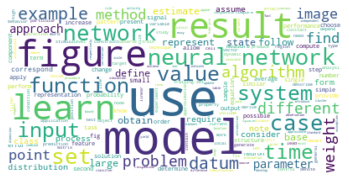

['database',
 'application',
 'efficient',
 'method',
 'self_organize',
 'associative',
 'database',
 'propose',
 'application',
 'robot',
 'eyesight',
 'system',
 'propose',
 'database',
 'associate',
 'input',
 'output',
 'half',
 'discussion',
 'algorithm',
 'self',
 'propose',
 'aspect',
 'hardware',
 'produce',
 'new',
 'style',
 'neural',
 'network',
 'half',
 'applicability',
 'handwritten',
 'letter',
 'recognition',
 'autonomous_mobile',
 'robot',
 'system',
 'demonstrate',
 'introduction',
 'let',
 'mapping',
 'finite',
 'infinite',
 'set',
 'finite',
 'infinite',
 'set',
 'learning',
 'machine',
 'observe',
 'set',
 'pair',
 'sample',
 'randomly',
 'mean',
 'cartesian',
 'product',
 'compute',
 'estimate',
 'small',
 'estimation',
 'error',
 'measure',
 'usually',
 'faster',
 'decrease',
 'estimation',
 'error',
 'increase',
 'number',
 'sample',
 'learn',
 'machine',
 'expression',
 'performance',
 'incomplete',
 'lack',
 'consideration',
 'candidate',
 'assume',
 'prelimin

In [34]:
nips_cleaned = clean_data(df_nips, "paper_text")
# nips_cleaned = nips_cleaned[:500]
nips_prepared = prepare_data(nips_cleaned.values)
nips_prepared[0]

## Creating dictionary

In [35]:
data = nips_prepared
len(data)

1000

In [36]:
id2word = corpora.Dictionary(data)

In [37]:
print(len(id2word))
id2word.filter_extremes(no_above=0.5, no_below=5)
# id2word.filter_n_most_frequent(15)
print(len(id2word))

corpus_all = [id2word.doc2bow(text) for text in data]
corpus_train = corpus_all[:int(2*len(data)/3)]
corpus_test = corpus_all[int(2*len(data)/3):]

27761
6477


## Creating and visualising default model

In [38]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=2)

measure_model(lda_model, corpus_test, data, id2word)

-7.719575434761505
-1.1603177728863936


   Num Documents  \
0            417   
1            181   
2            162   
3            154   
4             86   

                                                                                                                                                                                     Words  
0   (0, 0.021*"neuron" + 0.020*"cell" + 0.013*"stimulus" + 0.012*"response" + 0.010*"activity" + 0.008*"spike" + 0.008*"synaptic" + 0.007*"layer" + 0.007*"connection" + 0.006*"cortical")  
1        (1, 0.008*"class" + 0.007*"mixture" + 0.006*"gaussian" + 0.005*"matrix" + 0.005*"bound" + 0.005*"approximation" + 0.005*"hide" + 0.005*"let" + 0.005*"binary" + 0.005*"sequence")  
2                  (2, 0.029*"image" + 0.012*"object" + 0.011*"signal" + 0.008*"face" + 0.008*"circuit" + 0.007*"chip" + 0.007*"motion" + 0.007*"filter" + 0.007*"visual" + 0.006*"human")  
3       (3, 0.014*"action" + 0.013*"control" + 0.013*"policy" + 0.011*"optimal" + 0.008*"reinforcement" + 0.007*"dynamic" +

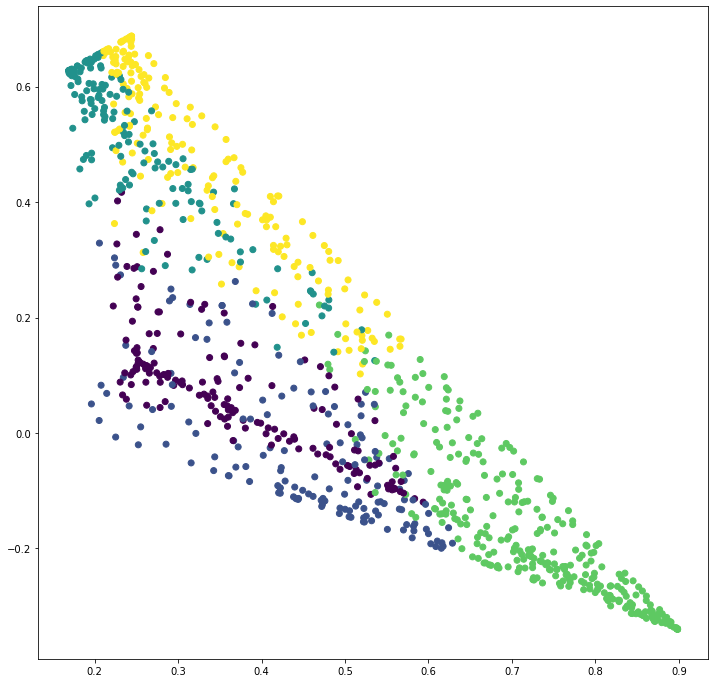

In [39]:
create_clusters_svd(lda_model)

In [41]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_all, id2word, sort_topics=False)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.159469  0.055073       1        1  16.508327
1      0.098603  0.002074       2        1  35.321552
2     -0.132171 -0.070389       3        1  20.027690
3      0.087370  0.116116       4        1  16.021065
4      0.105667 -0.102875       5        1  12.121366, topic_info=           Term         Freq        Total Category  logprob  loglift
215       image  5054.000000  5054.000000  Default  30.0000  30.0000
599      neuron  3070.000000  3070.000000  Default  29.0000  29.0000
503        cell  3300.000000  3300.000000  Default  28.0000  28.0000
2788     policy  1615.000000  1615.000000  Default  27.0000  27.0000
695      action  1899.000000  1899.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
433   technique   333.875544  1437.978366   Topic5  -5.6164   0.6500
286        node   320.550607  1751.255714   Topic5  -5.6571   0.4122
538      energy   301.449322   851.727830   Topic5  -5.7185   1.0715
310    positive   305.845994  1267.935467   Topic5  -5.7040   0.6881
247       level   307.146413  1605.324319   Topic5  -5.6998   0.4564

[393 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
695       1  0.027908  action
695       2  0.015271  action
695       3  0.052657  action
695       4  0.899384  action
695       5  0.005266  action
...     ...       ...     ...
470       1  0.035028    word
470       2  0.626925    word
470       3  0.228753    word
470       4  0.003574    word
470       5  0.105798    word

[1211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

## Creating and visualising hyperparametrized model

In [43]:
model_topic_results = {'num_topics': [],
                          'coherence': []
                      }
for num_topics in range(2, 15):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            random_state=100,
                                            chunksize=100,
                                            passes=2)
    coherence_model = CoherenceModel(model=model, texts=data, dictionary=id2word, coherence='u_mass')
    coh = coherence_model.get_coherence()
    model_topic_results['num_topics'].append(num_topics)
    model_topic_results['coherence'].append(coh)

best_topic_res = max(model_topic_results['coherence'])
i = model_topic_results['coherence'].index(best_topic_res)
best_topic = model_topic_results['num_topics'][i]
for x in model_topic_results:
    print(x)
    print(model_topic_results[x][i])

num_topics
2
coherence
-1.0129238631062938


In [44]:
topic_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                            id2word=id2word,
                                            num_topics=best_topic,
                                            random_state=100,
                                            chunksize=100,
                                            passes=2)
measure_model(topic_model, corpus_test, data, id2word)
create_clusters_svd(topic_model)

-7.691613731511993
-1.0129238631062938
   Num Documents  \
0            647   
1            353   

                                                                                                                                                                                  Words  
0  (0, 0.015*"image" + 0.011*"cell" + 0.009*"neuron" + 0.008*"response" + 0.007*"signal" + 0.007*"object" + 0.006*"stimulus" + 0.006*"visual" + 0.005*"activity" + 0.005*"recognition")  
1     (1, 0.005*"class" + 0.005*"optimal" + 0.005*"gaussian" + 0.004*"matrix" + 0.004*"action" + 0.004*"policy" + 0.004*"approximation" + 0.004*"mixture" + 0.004*"hide" + 0.004*"let")  
only two clusters


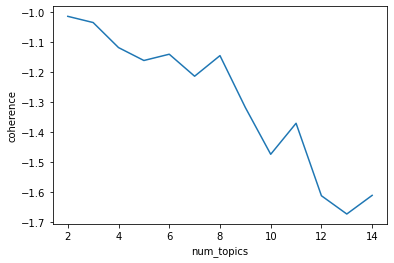

In [45]:
plt.plot(model_topic_results['num_topics'], model_topic_results['coherence'])
plt.xlabel("num_topics")
plt.ylabel("coherence")
plt.show()

In [47]:
best_model = hypertuning(corpus_train, id2word, data, 7)
measure_model(best_model, corpus_test, data, id2word)
create_clusters_svd(best_model)

-1.0200555720989883
-1.0927500198512639
-1.136562180443203
-1.0110865579483077
-1.1192311177988314
-1.1370308698292757
-1.0129238631062938
-1.1269131446220606
-1.148891194259313
-1.0836488586099289
-1.177720996464667
-1.1511144970816982
-1.0836488586099289
-1.1148438991096754
-1.1624753607162992
-1.0129238631062938
-1.117204789062448
-1.1393747261107936
-1.0193746414389995


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


-1.0819108819412353
-1.135092320872574
-7.6945520042678925
-1.0110865579483077
   Num Documents  \
0            649   
1            351   

                                                                                                                                                                                  Words  
0  (0, 0.016*"image" + 0.011*"cell" + 0.009*"neuron" + 0.008*"response" + 0.007*"signal" + 0.007*"object" + 0.006*"stimulus" + 0.006*"visual" + 0.005*"activity" + 0.005*"recognition")  
1     (1, 0.005*"class" + 0.005*"optimal" + 0.005*"gaussian" + 0.004*"matrix" + 0.004*"action" + 0.004*"policy" + 0.004*"approximation" + 0.004*"mixture" + 0.004*"hide" + 0.004*"let")  
only two clusters


In [48]:
print(best_model.eta[0])
print(best_model.num_topics)
print(best_model.chunksize)
distr = [best_model[corpus_all[i]]for i in range(len(data))]

top_topics = [max(i,key=lambda item:item[1]) for i in distr]

df_topic_distribution = pd.DataFrame(top_topics, columns =['Topic', 'Value'])
df_topic_distribution = df_topic_distribution['Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution['Words'] = best_model.show_topics(num_words=10, log=False, formatted=True)
df_topic_distribution.columns = ['Topic Num', 'Num Documents', 'Words']
df_topic_distribution.drop('Topic Num', axis=1, inplace=True)
pd.set_option('max_colwidth', 400)
df_topic_distribution

0.3
2
100


,Num Documents,Words
0,649,"(0, 0.016*""image"" + 0.011*""cell"" + 0.009*""neuron"" + 0.008*""response"" + 0.007*""signal"" + 0.007*""object"" + 0.006*""stimulus"" + 0.006*""visual"" + 0.005*""activity"" + 0.005*""recognition"")"
1,351,"(1, 0.005*""class"" + 0.005*""optimal"" + 0.005*""gaussian"" + 0.004*""matrix"" + 0.004*""action"" + 0.004*""policy"" + 0.004*""approximation"" + 0.004*""mixture"" + 0.004*""hide"" + 0.004*""let"")"


In [49]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_model, corpus_all, id2word, sort_topics=False)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.108312  0.0       1        1  38.859305
1     -0.108312  0.0       2        1  61.140695, topic_info=         Term         Freq        Total Category  logprob  loglift
215     image  5170.000000  5170.000000  Default  30.0000  30.0000
503      cell  3248.000000  3248.000000  Default  29.0000  29.0000
599    neuron  2967.000000  2967.000000  Default  28.0000  28.0000
364  response  2387.000000  2387.000000  Default  27.0000  27.0000
840  stimulus  1770.000000  1770.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
251     local  1578.774115  2309.961545   Topic2  -5.6809   0.1114
250      line  1538.224281  2253.910222   Topic2  -5.7070   0.1100
600     noise  1703.444187  2828.559005   Topic2  -5.6049  -0.0151
96    control  1550.824468  2819.624927   Topic2  -5.6988  -0.1058
532  distance  1289.973415  1645.062751   Topic2  -5.8830   0.2488

[188 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
695       1  0.110814         action
695       2  0.889192         action
475       1  0.977490       activity
475       2  0.022075       activity
4323      1  0.006813       adaboost
...     ...       ...            ...
691       2  0.005761  visual_cortex
5863      1  0.006093  visualisation
5863      2  0.993082  visualisation
1652      1  0.972898        voltage
1652      2  0.027949        voltage

[295 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

# Exp3

## Data preparation

In [50]:
df_nips_text_and_year = df_nips[['year', 'paper_text']]
nips_grouped = [d for _, d in df_nips_text_and_year.groupby(['year'])]
nips_grouped


[     year  \
 0    1987   
 1    1987   
 111  1987   
 219  1987   
 328  1987   
 438  1987   
 546  1987   
 654  1987   
 764  1987   
 872  1987   
 983  1987   
 
                                                                                                                                                                                                                                                                                                                                                                                                           paper_text  
 0    767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABASE\nAND ITS APPLICATIONS\nHisashi Suzuki and Suguru Arimoto\nOsaka University, Toyonaka, Osaka 560, Japan\nABSTRACT\nAn efficient method of self-organizing associative databases is proposed together with\napplications to robot eyesight systems. The proposed databases can associate any input\nwith some output. In the first half part of discussion, a...  
 1    683\n\nA

## Creating and visualising a model

In [56]:
def create_model(id2word, corpus_all, corpus_test, corpus_train, data):

  best_model = hypertuning(corpus_train, id2word, data)
  print("Model results")
  measure_model(best_model, corpus_test, data, id2word)
  create_clusters_svd(best_model)

  return best_model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
715591
['an', 'adaptive', 'network', 'that', 'learns', 'sequences', 'of', 'transitions', 'winter', 'science', 'applications', 'international', 'corporation', 'east', 'broadway', 'suite', 'tucson', 'auizona', 'abstract', 'we', 'describe', 'an', 'adaptive', 'network', 'tin', 'that', 'learns', 'the', 'transition', 'function', 'of', 'sequential', 'system', 'from', 'observations', 'of', 'its', 'behavior', 'it', 'integrates', 'two', 'subnets', 'tin', 'winter', 'ryan', 'and', 'turner', 'and', 'tin', 'tin']
Pocet slov po vymazani dvojpismenkovych a menej slov:
334566
1243
['adaptive', 'network', 'learn', 'sequence', 'transition', 'science', 'describe', 'adaptive', 'network', 'tin', 'learn', 'transition', 'function', 'sequential', 'system', 'observation', 'behavior', 'integrate', 'subnet', 'winter', 'construct', 'state', 'representation', 'example', 'system', 'behavior', 'dynamic', 'main', 'topic', 'paper', 'abstract', 'transition', 'function', 'noisy', 

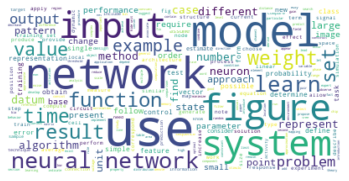

274
13637
3281
-1.1561822295965365
-1.252873221698451
-1.2085726855725956
-1.248716907608297
-1.6217496980596746
-1.7112742247671264
-1.7440069573877666
-1.2012640327092516
-1.2431151240030776
-1.0954953545629256
-1.1957821036319798
-1.210615114919128
-1.2427231941666286
-1.2342396446054444
-1.1564302266787276
-1.250966794788601
-1.1677325371264955
-1.3097755218184606
-1.6304753991413254
-1.6076711406019957
-1.6442507030553641
-1.2029490450755294
-1.2486849773285997
-1.0929829324909013
-1.205488022742546
-1.2105380603073619
-1.2532658661053615
-1.210162230908154
-1.1477422066105514
-1.2811459600398607
-1.1779176434465684
-1.3824149694717724
-1.600123018475222
-1.694779396436086
-1.6433137822525123
-1.2029490450755294
-1.247249649399405
-1.1119355847723753
-1.2098745435985228
-1.2109938154237931
-1.301941997196209
-1.2355509786064613
-1.1478618444370692
-1.2799746931909042
-1.1967552609208525
-1.4802338911779795
-1.6832376530396913
-1.7598313671955024
-1.6910576605354453
-1.202949045075

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: FutureWarning: The default value of regex will change from True to False in a future version.


Povodny text po tokenizacii, pocet slov:
1987502
['on', 'reversing', 'jensen', 'inequality', 'tony', 'jebara', 'mit', 'media', 'lab', 'cambridge', 'ma', 'alex', 'pentland', 'mit', 'media', 'lab', 'cambridge', 'ma', 'abstract', 'jensen', 'inequality', 'is', 'powerful', 'mathematical', 'tool', 'and', 'one', 'of', 'the', 'workhorses', 'in', 'statistical', 'learning', 'its', 'applications', 'therein', 'include', 'the', 'em', 'algorithm', 'bayesian', 'estimation', 'and', 'bayesian', 'inference', 'jensen', 'computes', 'simple', 'lower', 'bounds']
Pocet slov po vymazani dvojpismenkovych a menej slov:
920943
1176
['reverse', 'powerful', 'mathematical', 'tool', 'workhorse', 'statistical', 'learn', 'application', 'include', 'inference', 'compute', 'simple', 'low', 'bound', 'intractable', 'quantity', 'product', 'sum', 'latent', 'log_likelihood', 'simplification', 'permit', 'operation', 'integration', 'maximization', 'discriminative', 'learn', 'upper', 'bound', 'need', 'derive', 'prove', 'efficien

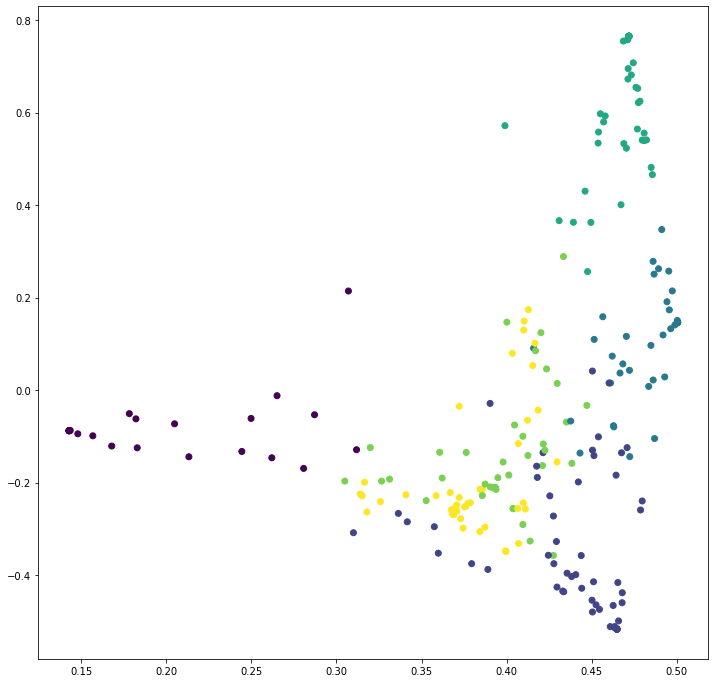

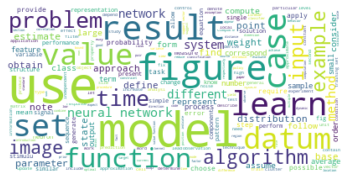

726
22394
5442
-1.1440137488842668
-1.0861512169952785
-1.25079329989749
-1.1525647233320775
-1.4594683695841226
-1.4551099794740654
-1.3608578828947182
-1.064725339120832
-1.0822398775180382
-1.0928129119000414
-1.2466406710628162
-1.2856812403276288
-1.2181652198989774
-1.2218539907703299
-1.1425300947629116
-1.0643107064331239
-1.2753972942841172
-1.1423269252242205
-1.5213981092886524
-1.4690166182910849
-1.4620696190319273
-1.0637681667473178
-1.0744279007705186
-1.1083934173560095
-1.2002887611306465
-1.2817089096687222
-1.2772839265830205
-1.2483576200706228
-1.12838076444159
-1.1063941915760351
-1.1697813310172966
-1.1040586136139878
-1.505145798436789
-1.4717652640337047
-1.425394165637562
-1.0638532161979892
-1.0743187967315209
-1.0978784334508382
-1.182786668889652
-1.377312972951218
-1.3274135296045622
-1.2615723626628168
-1.1258924728390864
-1.1052236118419547
-1.187158475194865
-1.1017619259365432
-1.5340538374448556
-1.5016973359973422
-1.442127902584271
-1.0619309682164

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


-1.1402241783971188
-1.0721961066581354
-1.2409554642543512
-1.123247096967094
-1.4542712045176323
-1.4127489357840561
-1.341958402107018
-1.0638532161979892
-1.0742879265553102
-1.110342356579503
-1.1627392565216739
-1.293214000052202
-1.2155160546431398
-1.215720203762755
Model results
-7.695574494330676
-1.061064245140555
   Num Documents  \
0            394   
1            332   

                                                                                                                                                                                             Words  
0                    (0, 0.011*"image" + 0.007*"cell" + 0.006*"filter" + 0.005*"signal" + 0.005*"response" + 0.005*"neuron" + 0.005*"noise" + 0.005*"stimulus" + 0.005*"control" + 0.004*"object")  
1  (1, 0.006*"gaussian" + 0.005*"kernel" + 0.005*"class" + 0.005*"approximation" + 0.004*"noise" + 0.004*"matrix" + 0.004*"prediction" + 0.004*"bound" + 0.004*"classification" + 0.003*"machine")  
only two clusters


ValueError: ignored

In [57]:
all_models = []
all_dictionaries = []
all_corpuses = []
for i in range(0, 30, 5):
  data = pd.concat([pd.DataFrame(d) for d in nips_grouped[i:i+5]])
  data.reset_index(inplace=True)
  data = clean_data(data, "paper_text")
  random.shuffle(data)
  data = prepare_data(data.values)
  print(len(data))
  id2word = corpora.Dictionary(data)
  print(len(id2word))
  id2word.filter_extremes(no_above=0.5, no_below=5)
  print(len(id2word))
  
  corpus_all = [id2word.doc2bow(text) for text in data]
  corpus_train = corpus_all[:int(2*len(data)/3)]
  corpus_test = corpus_all[int(2*len(data)/3):]

  final_model = create_model(id2word, corpus_all, corpus_test, corpus_train, data)
  all_models.append(final_model)
  all_dictionaries.append(id2word)
  all_corpuses.append(corpus_all)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(all_models[0], all_corpuses[0], all_dictionaries[0])
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.099863  0.030267       1        1  30.024075
5     -0.127335 -0.043104       2        1  16.852836
3      0.025622  0.123965       3        1  14.805704
2      0.071635 -0.131175       4        1  14.703048
4      0.185604  0.020186       5        1  14.099950
0     -0.055663 -0.000139       6        1   9.514387, topic_info=              Term         Freq        Total Category  logprob  loglift
464          image  4137.000000  4137.000000  Default  30.0000  30.0000
36            cell  4312.000000  4312.000000  Default  29.0000  29.0000
270           rule  3205.000000  3205.000000  Default  28.0000  28.0000
2013         spike  1720.000000  1720.000000  Default  27.0000  27.0000
250    recognition  2586.000000  2586.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
320      threshold   273.839860  1517.785089   Topic6  -5.7371   0.6399
9         analysis   254.280326  1452.463196   Topic6  -5.8112   0.6098
13    architecture   270.995506  2514.372763   Topic6  -5.7476   0.1247
62      connection   269.005888  2395.671493   Topic6  -5.7549   0.1657
501         object   247.830481  1958.485480   Topic6  -5.8369   0.2852

[519 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
345       1  0.259934  accuracy
345       2  0.552360  accuracy
345       3  0.063014  accuracy
345       4  0.040369  accuracy
345       5  0.016738  accuracy
...     ...       ...       ...
756       3  0.036073      word
756       4  0.014638      word
756       5  0.009410      word
756       6  0.012547      word
4022      2  0.996144    writer

[1757 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 4, 3, 5, 1])